In [3]:
import pandas as pd
import numpy as np 
import glob
import os
import matplotlib.pyplot as plt 
import lightgbm as lgbm
import warnings
import seaborn as sns


### Helper Functions

In [4]:
def wap(df):
        return (df['bid_price1'] * df['ask_size1'] +
                df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])

def wap2(df):
    return (df['bid_price2'] * df['ask_size2'] +
            df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])

def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

def realized_volatility(returns):
    return np.sqrt(np.sum(returns ** 2))

def count_unique(series):
    return len(np.unique(series))

def isValidStock(i):
    filename = "stock_trade_train/stock_" + str(i) + "_train.parquet"
    if not os.path.exists(filename):
        return False
    return True

def RMSPEMetric():

    def RMSPE(yhat, dtrain):
        y = dtrain.get_label()
        elements = ((y - yhat) / y) ** 2
        return 'RMSPE', float(np.sqrt(np.sum(elements) / len(y))), False

    return RMSPE

### Getting Dataset

In [5]:
def book_predictors(stock_id, train_or_test):
    stock_data = pd.read_parquet('stock_book_' + train_or_test + '/stock_' + str(stock_id) + '_' + train_or_test + '.parquet')
    stock_data['wap'] = wap(stock_data)
    stock_data['log_return'] = stock_data.groupby('time_id')['wap'].apply(log_return)
    stock_data['wap2'] = wap2(stock_data)
    stock_data['log_return2'] = stock_data.groupby('time_id')['wap2'].apply(log_return)
    stock_data['wap_offset'] = abs(stock_data['wap'] - stock_data['wap2'])
    stock_data['price_spread'] = (stock_data['ask_price1'] - stock_data['bid_price1']) / ((stock_data['ask_price1'] + stock_data['bid_price1']) / 2)
    stock_data['bid_spread'] = stock_data['bid_price1'] - stock_data['bid_price2']
    stock_data['ask_spread'] = stock_data['ask_price1'] - stock_data['ask_price2']
    stock_data['total_volume'] = (stock_data['ask_size1'] + stock_data['ask_size2']) + (stock_data['bid_size1'] + stock_data['bid_size2'])
    stock_data['volume_imbalance'] = abs((stock_data['ask_size1'] + stock_data['ask_size2']) - (stock_data['bid_size1'] + stock_data['bid_size2']))

    create_feature_dict = {
            'log_return':[realized_volatility],
            'log_return2':[realized_volatility],
            'wap_offset':[np.mean],
            'price_spread':[np.mean],
            'bid_spread':[np.mean],
            'ask_spread':[np.mean],
            'volume_imbalance':[np.mean],
            'total_volume':[np.mean],
            'wap':[np.mean],
    }

    result = pd.DataFrame(stock_data.groupby(['time_id']).agg(create_feature_dict)).reset_index()
    result.columns = result.columns.map('_'.join).str.strip('_')

    return result

def trade_predictors(stock_id, train_or_test):
    stock_data = pd.read_parquet('stock_trade_' + train_or_test + '/stock_' + str(stock_id) + '_' + train_or_test + '.parquet')

    stock_data['log_return'] = stock_data.groupby('time_id')['price'].apply(log_return)
    
    
    aggregate_dictionary = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.mean],
    }

    result = pd.DataFrame(stock_data.groupby('time_id').agg(aggregate_dictionary)).reset_index()
    result.columns = result.columns.map('_'.join).str.strip('_')
    return result

def target(stock_id, train_or_test):
    result = pd.read_parquet('target_data/target_' + train_or_test + '.parquet')
    result = result.loc[result['stock_id'] == stock_id]
    result = result.drop(['stock_id'], axis = 1)
    return result

def generate_data(stock_id, train_or_test):
    result = pd.merge(target(stock_id, train_or_test), book_predictors(stock_id, train_or_test), on='time_id', how='left')
    result = pd.merge(result, trade_predictors(stock_id, train_or_test), on='time_id', how='left')
    result['stock_id'] = stock_id
    return result

def generate_train_and_test(stock_id):
    train = generate_data(stock_id, 'train')
    test = generate_data(stock_id, 'test')

    X_train = train.drop(['target', 'time_id'], axis = 1)
    X_test = test.drop(['target', 'time_id'], axis = 1)

    y_train = train['target']
    y_test = test['target']

    return X_train, X_test, y_train, y_test

### Getting combined Dataframes

In [6]:
total = 0
total_size = 0
warnings.filterwarnings("ignore")

X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.DataFrame()
y_test = pd.DataFrame()

for i in range(127):
    if not isValidStock(i):
        continue

    a, b, c, d = generate_train_and_test(i)

    X_train = pd.concat([X_train, a])
    X_test = pd.concat([X_test, b])
    y_train = pd.concat([y_train, c])
    y_test = pd.concat([y_test, d])


In [11]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

### Implementing LGBM

In [41]:
params_lgbm = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'objective': 'rmse',
        'n_jobs': 8,
        'verbose': -1
    }
weights = 1/(y_train[0] ** 2)
lgbm_train_data = lgbm.Dataset(X_train, label=y_train[0], weight=weights)

weights = 1/(y_test[0] ** 2)
lgbm_test_data = lgbm.Dataset(X_test, label=y_test[0], weight=weights)
rounds = 100000
model = lgbm.train(params_lgbm, 
                    lgbm_train_data, 
                    rounds, 
                    valid_sets=lgbm_test_data,
                    feval=RMSPEMetric(),
                    verbose_eval = 500,
                    early_stopping_rounds=10000,
                    categorical_feature = ['stock_id']
                    )


Training until validation scores don't improve for 10000 rounds
[500]	valid_0's l2: 2.61432e-07	valid_0's RMSPE: 0.241025
[1000]	valid_0's l2: 2.59897e-07	valid_0's RMSPE: 0.240317
[1500]	valid_0's l2: 2.61017e-07	valid_0's RMSPE: 0.240834
[2000]	valid_0's l2: 2.61163e-07	valid_0's RMSPE: 0.240901
[2500]	valid_0's l2: 2.6142e-07	valid_0's RMSPE: 0.241019
[3000]	valid_0's l2: 2.61526e-07	valid_0's RMSPE: 0.241068
[3500]	valid_0's l2: 2.61832e-07	valid_0's RMSPE: 0.24121
[4000]	valid_0's l2: 2.61887e-07	valid_0's RMSPE: 0.241235
[4500]	valid_0's l2: 2.61962e-07	valid_0's RMSPE: 0.241269
[5000]	valid_0's l2: 2.62023e-07	valid_0's RMSPE: 0.241298
[5500]	valid_0's l2: 2.62072e-07	valid_0's RMSPE: 0.24132
[6000]	valid_0's l2: 2.62332e-07	valid_0's RMSPE: 0.24144
[6500]	valid_0's l2: 2.62337e-07	valid_0's RMSPE: 0.241442
[7000]	valid_0's l2: 2.62564e-07	valid_0's RMSPE: 0.241546
[7500]	valid_0's l2: 2.62794e-07	valid_0's RMSPE: 0.241652
[8000]	valid_0's l2: 2.62925e-07	valid_0's RMSPE: 0.2417

### Calculating feature importance

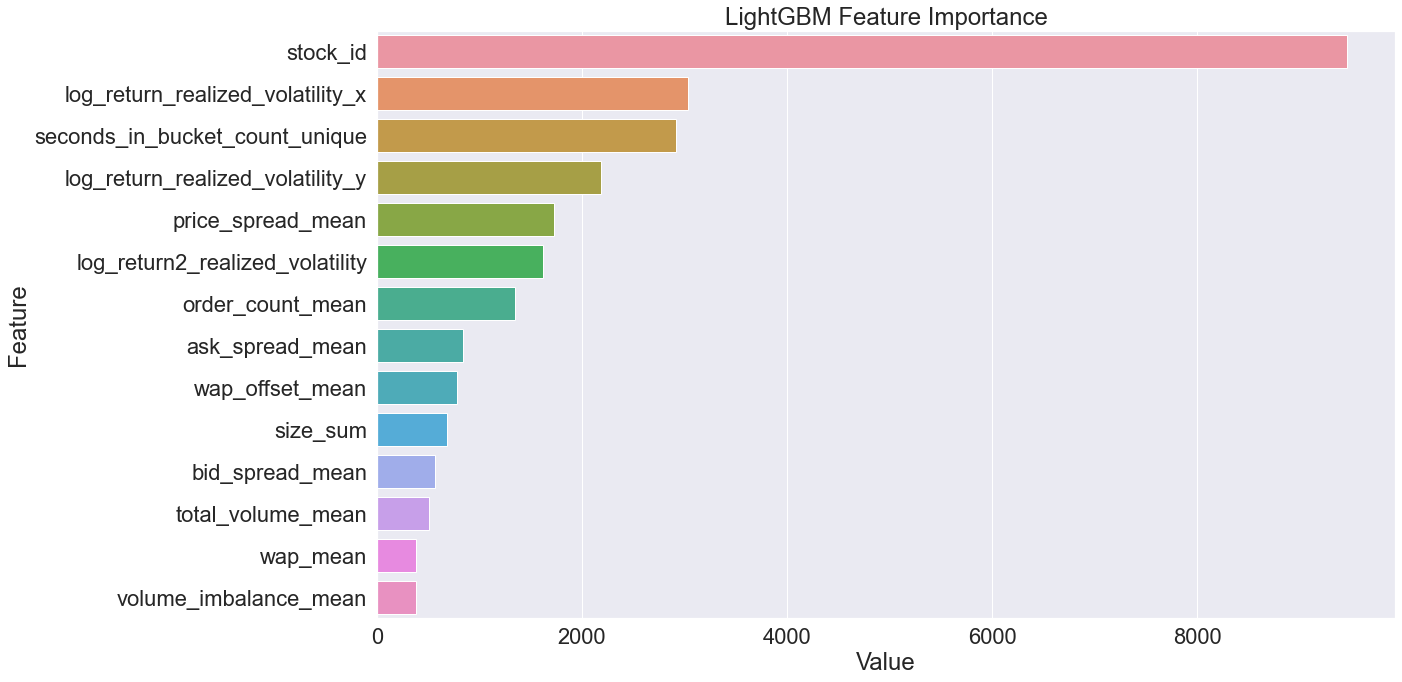

In [42]:
def plotImp(model, X , num = 20, fig_size = (20, 10)):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 2)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title('LightGBM Feature Importance')
    plt.tight_layout()
    plt.show()

plotImp(model, X_train)